In [1]:
%matplotlib inline
import geopandas as gpd
import folium 
import json
import pandas as pd
import numpy as np

from folium.plugins import HeatMap
from folium.plugins import MarkerCluster
import branca.colormap as cm
from sklearn.cluster import DBSCAN

import matplotlib.pyplot as plt
import pickle
import networkx as nx
from scipy import spatial

In [2]:
def WGS84toDutchRD(wgs84East, wgs84North):
    # translated from Peter Knoppers's code

    # wgs84East: longtitude
    # wgs84North: latitude

    # Western boundary of the Dutch RD system. */
    WGS84_WEST_LIMIT = 3.2

    # Eastern boundary of the Dutch RD system. */
    WGS84_EAST_LIMIT = 7.3

    # Northern boundary of the Dutch RD system. */
    WGS84_SOUTH_LIMIT = 50.6

    # Southern boundary of the Dutch RD system. */
    WGS84_NORTH_LIMIT = 53.7

    if (wgs84North > WGS84_NORTH_LIMIT) or \
        (wgs84North < WGS84_SOUTH_LIMIT) or \
        (wgs84East < WGS84_WEST_LIMIT) or \
        (wgs84East > WGS84_EAST_LIMIT):
        resultX = -1
        resultY = -1
    else:
        r = [[155000.00, 190094.945,   -0.008, -32.391, 0.0],
            [-0.705, -11832.228,    0.0  ,   0.608, 0.0],
            [0.0  ,   -114.221,    0.0  ,   0.148, 0.0],
            [0.0  ,     -2.340,    0.0  ,   0.0  , 0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  , 0.0]]
        s = [[463000.00 ,      0.433, 3638.893,   0.0  ,  0.092],
            [309056.544,     -0.032, -157.984,   0.0  , -0.054],
            [73.077,      0.0  ,   -6.439,   0.0  ,  0.0],
            [59.788,      0.0  ,    0.0  ,   0.0  ,  0.0],
            [0.0  ,      0.0  ,    0.0  ,   0.0  ,  0.0]]
        resultX = 0
        resultY = 0
        powNorth = 1
        dNorth = 0.36 * (wgs84North - 52.15517440)
        dEast = 0.36 * (wgs84East - 5.38720621)

        for p in range(5):
            powEast = 1
            for q in range(5):
                resultX = resultX + r[p][q] * powEast * powNorth
                resultY = resultY + s[p][q] * powEast * powNorth
                powEast = powEast * dEast
            powNorth = powNorth * dNorth
    return resultX, resultY

In [3]:
G = pickle.load(open('NetworkX_graph_new.pickle', 'rb'))

In [4]:
# travel_time function
def travel_time_func(point1, point2):
    """This function should use the information given in network X to return the travel time between two points"""

    # Change points to Dutch system
    p1_x, p1_y = WGS84toDutchRD(point1[0], point1[1]) # inspector
    p2_x, p2_y = WGS84toDutchRD(point2[0], point2[1]) # incident

    # Create numpy matrix from nodes
    A = np.array(list(G.nodes()))

    # Get node closest to each point
    dist_node1, index_node1 = spatial.KDTree(A).query([p1_x, p1_y])
    node1 = (A[index_node1][0], A[index_node1][1])

    dist_node2, index_node2 = spatial.KDTree(A).query([p2_x, p2_y])
    node2 = (A[index_node2][0], A[index_node2][1])

    # Get shortest path between nodes
    route = nx.shortest_path(G, node1, node2, 'Min_travel_time_[s]')
    travel_time = nx.shortest_path_length(G, node1, node2, 'Min_travel_time_[s]')

    # print(f'Distance to node 1: {dist_node1}')
    # print(f'Distance to node 2: {dist_node2}')
    # print(f'Travel time: {travel_time:.0f} [s]')

    return route, travel_time

In [5]:
incidents = pd.read_csv('Dashboard_data\incidents_data', sep=';')

In [6]:
p1 = (incidents.iloc[0].longitude, incidents.iloc[0].latitude)
p2 = (incidents.iloc[521].longitude, incidents.iloc[521].latitude)

In [7]:
short_path, time = travel_time_func(p1, p2)

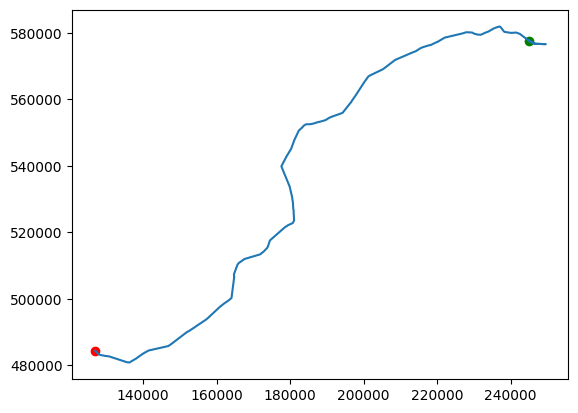

In [8]:
plt.figure()
short_path, time = travel_time_func(p1, p2)
B = np.array(short_path)

plt.plot(B[:, 0], B[:, 1])
plt.scatter(WGS84toDutchRD(p1[0], p1[1])[0], WGS84toDutchRD(p1[0], p1[1])[1], color='r')
plt.scatter(WGS84toDutchRD(p2[0], p2[1])[0], WGS84toDutchRD(p2[0], p2[1])[1], color='g')